In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

In [2]:
#the excelbook had two sheets so I had to save them individually
df1 = pd.read_csv('online_retail_2010-2011.csv')
df2 = pd.read_csv('online_retail_2009-2010.csv')

In [3]:
#combine both years
data = pd.concat([df1, df2], ignore_index=True)

In [4]:
#delete duplicate rows
data = data.drop_duplicates()

In [5]:
#check to see if deleting rows with missing data is viable

initial_row_count = len(data)
print(f"Initial number of rows: {initial_row_count}")

# Drop rows with any missing data
data_cleaned = data.dropna()


final_row_count = len(data_cleaned)
print(f"Number of rows after removing rows with empty data: {final_row_count}")

Initial number of rows: 1033036
Number of rows after removing rows with empty data: 797885


In [6]:
missing_counts = data.isnull().sum()
missing_percentages = (missing_counts / len(data)) * 100
missing_summary = pd.DataFrame({
    'Missing Values': missing_counts,
    'Percentage (%)': missing_percentages
})
missing_summary_sorted = missing_summary.sort_values(by='Missing Values', ascending=False)
print(missing_summary_sorted)

             Missing Values  Percentage (%)
Customer ID          235151       22.763098
Description            4275        0.413829
Invoice                   0        0.000000
StockCode                 0        0.000000
Quantity                  0        0.000000
InvoiceDate               0        0.000000
Price                     0        0.000000
Country                   0        0.000000


In [7]:
#The VAST majority of the missing data is in the customer ID column. This means it is probably best to have two dataframes. One with cleanedrows for where customer ID is crucial and one without where customer ID doesn't matter

In [8]:
#Since none of the following graphs involve Costumer ID at all we can rely on the larger dataset.
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], format='%m/%d/%Y %H:%M')
print(data['InvoiceDate'].head())

0   2010-12-01 08:26:00
1   2010-12-01 08:26:00
2   2010-12-01 08:26:00
3   2010-12-01 08:26:00
4   2010-12-01 08:26:00
Name: InvoiceDate, dtype: datetime64[ns]


In [9]:
data['Hour'] = data['InvoiceDate'].dt.hour
data['DayOfWeek'] = data['InvoiceDate'].dt.day_name()
data['Month'] = data['InvoiceDate'].dt.month

data['Revenue'] = data['Quantity'] * data['Price']

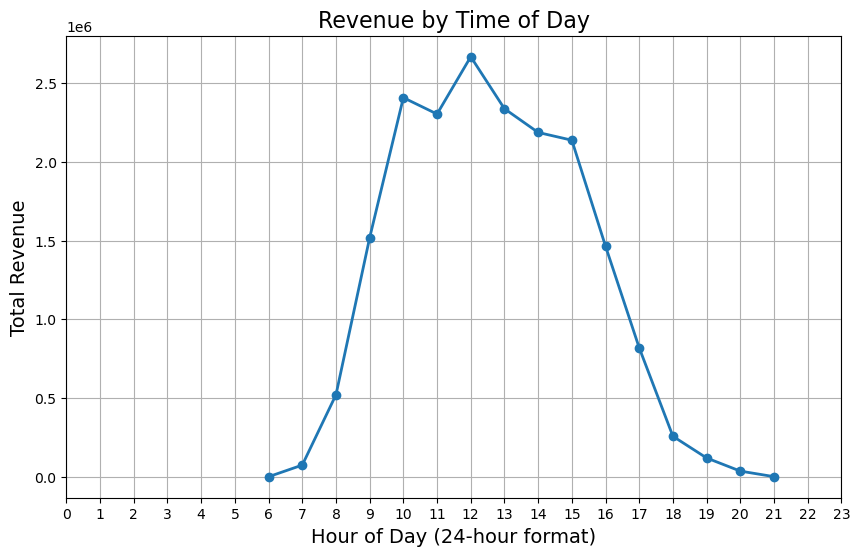

In [10]:
time_of_day_revenue = data.groupby('Hour')['Revenue'].sum()
plt.figure(figsize=(10, 6))
plt.plot(time_of_day_revenue.index, time_of_day_revenue.values, marker='o', linestyle='-', linewidth=2)
plt.title('Revenue by Time of Day', fontsize=16)
plt.xlabel('Hour of Day (24-hour format)', fontsize=14)
plt.ylabel('Total Revenue', fontsize=14)
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

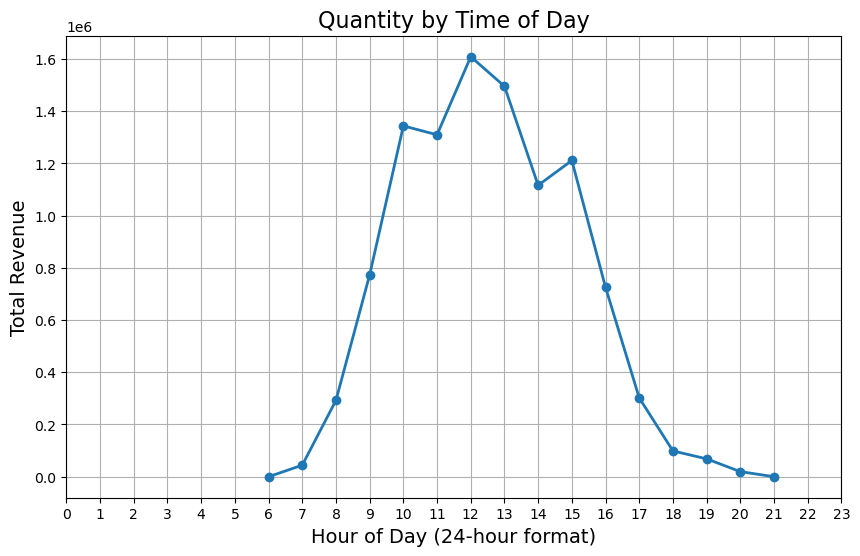

In [11]:
time_of_day_revenue = data.groupby('Hour')['Quantity'].sum()
plt.figure(figsize=(10, 6))
plt.plot(time_of_day_revenue.index, time_of_day_revenue.values, marker='o', linestyle='-', linewidth=2)
plt.title('Quantity by Time of Day', fontsize=16)
plt.xlabel('Hour of Day (24-hour format)', fontsize=14)
plt.ylabel('Total Revenue', fontsize=14)
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

In [12]:
#These results clearly show us that quantity of items bought and revenue to the store are fairly linked. This also shows us that the amount of both have a bell-esque curve peaking at noon.
#Interestingly, this data also shows us the opening and closing times of the store. Namely 6 am and closing at 9 pm. This is strange as the data is said to come from an online store

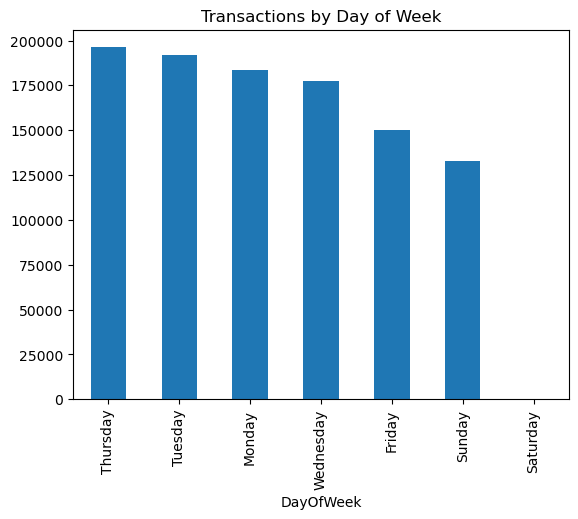

In [13]:
data['DayOfWeek'].value_counts().plot(kind='bar', title='Transactions by Day of Week')
plt.show()

In [14]:
#It seems as though people like to buy earlier in the week. Strangly there is no data on Saturday despite the data coming from an online store.

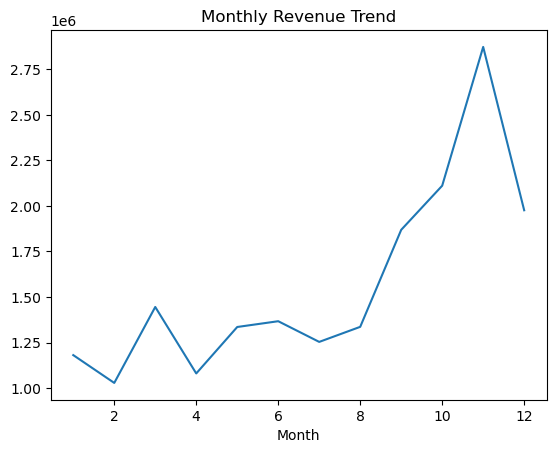

In [15]:
data.groupby('Month')['Revenue'].sum().plot(kind='line', title='Monthly Revenue Trend')
plt.show()

In [16]:
#as could be predicted the amount of purchases heavily spikes around holiday time. You can clearly see a massive spike in November. This could possibly be black friday sales.

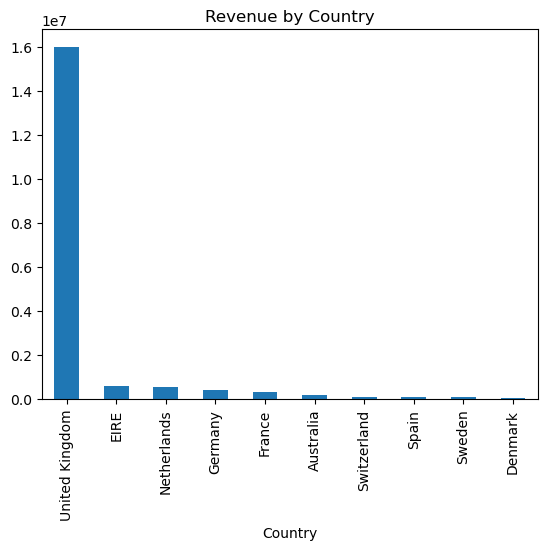

In [17]:
data.groupby('Country')['Revenue'].sum().sort_values(ascending=False).head(10).plot(kind='bar', title='Revenue by Country')
plt.show()

In [18]:
#also to be expected is the dominance of UK sales. This makes sense as the company is based within the United Kingdom

In [19]:
#TASK 2: Customer Segentation

In [20]:
print(data.columns)

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country', 'Hour', 'DayOfWeek', 'Month',
       'Revenue'],
      dtype='object')


In [21]:
# Group data by 'CustomerID' and aggregate purchase data
customer_data = data.groupby('Customer ID').agg(
    total_revenue=('Revenue', 'sum'),
    purchase_count=('Invoice', 'nunique'),  # Use 'Invoice' instead of 'InvoiceNo'
    avg_transaction_size=('Revenue', 'mean'),
    last_purchase_date=('InvoiceDate', 'max'),
    product_diversity=('StockCode', 'nunique')
)

# Create recency feature (days since last purchase)
customer_data['recency'] = (data['InvoiceDate'].max() - customer_data['last_purchase_date']).dt.days
customer_data = customer_data.drop(columns=['last_purchase_date'])  # Drop the date column as we now have recency


In [22]:
features = ['total_revenue', 'purchase_count', 'avg_transaction_size', 'recency', 'product_diversity']

scaler = StandardScaler()
customer_data_scaled = scaler.fit_transform(customer_data[features])

customer_data_scaled = pd.DataFrame(customer_data_scaled, columns=features, index=customer_data.index)

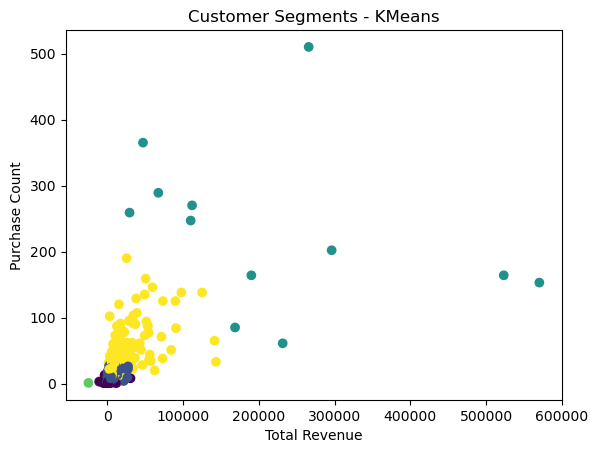

In [23]:
kmeans = KMeans(n_clusters=5, random_state=42)
customer_data['segment'] = kmeans.fit_predict(customer_data_scaled)

plt.scatter(customer_data['total_revenue'], customer_data['purchase_count'], c=customer_data['segment'], cmap='viridis')
plt.xlabel('Total Revenue')
plt.ylabel('Purchase Count')
plt.title('Customer Segments - KMeans')
plt.show()

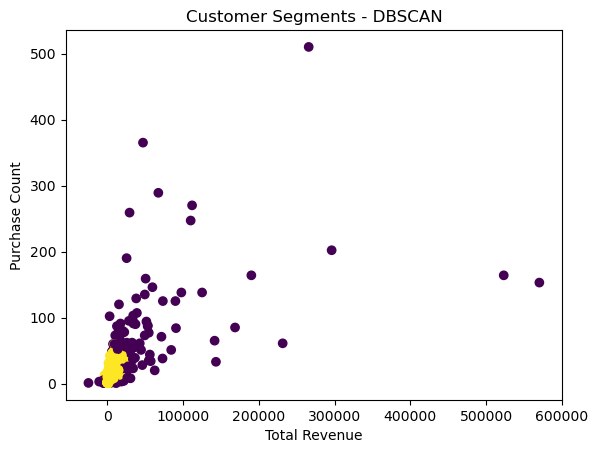

In [24]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=5)
customer_data['segment'] = dbscan.fit_predict(customer_data_scaled)

plt.scatter(customer_data['total_revenue'], customer_data['purchase_count'], c=customer_data['segment'], cmap='viridis')
plt.xlabel('Total Revenue')
plt.ylabel('Purchase Count')
plt.title('Customer Segments - DBSCAN')
plt.show()

In [25]:
segment_marketing = {
    0: 'Offer exclusive deals or loyalty rewards to high-value customers.',
    1: 'Provide discounts on bulk purchases for frequent shoppers.',
    2: 'Suggest personalized products or offer welcome-back promotions.',
    3: 'Target these customers with high-value promotions.',
    4: 'Send targeted offers for new products based on browsing behavior.',
}

customer_data['marketing_strategy'] = customer_data['segment'].map(segment_marketing)
print(customer_data[['segment', 'marketing_strategy']].head())

             segment                                 marketing_strategy
Customer ID                                                            
12346.0            0  Offer exclusive deals or loyalty rewards to hi...
12347.0            0  Offer exclusive deals or loyalty rewards to hi...
12348.0            0  Offer exclusive deals or loyalty rewards to hi...
12349.0            0  Offer exclusive deals or loyalty rewards to hi...
12350.0            0  Offer exclusive deals or loyalty rewards to hi...


In [26]:
customer_data = customer_data.merge(data[['Customer ID', 'InvoiceDate']], on='Customer ID', how='left')

customer_data['hour'] = customer_data['InvoiceDate'].dt.hour
customer_data['day_of_week'] = customer_data['InvoiceDate'].dt.dayofweek

In [27]:
communication_times = customer_data.groupby('segment').agg(
    most_common_hour=('hour', lambda x: x.mode()[0]),
    most_common_day=('day_of_week', lambda x: x.mode()[0])
)

communication_times['most_common_day'] = communication_times['most_common_day'].map({
    0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'
})

print(communication_times)

         most_common_hour most_common_day
segment                                  
-1                     12        Thursday
 0                     12        Thursday


In [28]:
# Task 3: Customer Purchase Prediction